## Setup and Data Loading

In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
import importlib

sys.path.append('../scripts/')
import FeatureEngineering
importlib.reload(FeatureEngineering)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [15]:

path = '../data/consolidated/'
weather_data = pd.read_csv(path+'consolidated_weather_from_centroids.csv')
demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')
price_data = pd.read_csv(path+'prices_zonal.csv')

# convert temperature
columns = list(weather_data.columns)
columns[0] = 'Hour'
weather_data.columns = columns
weather_data['temp_C_t2m'] = weather_data['t2m'] - 273.15

# create proper dataset
dataset = FeatureEngineering.CleanedDataset(weather_data, demand_data, price_data)
datamerged = dataset.merge_datasets()
datamerged = dataset.add_calendar_features(datamerged)

print(f"Dataset shape: {datamerged.shape}")

/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_2960/3273825869.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  demand_data = pd.read_csv(path+'consolidatedIESOdemand.csv')


Dataset shape: (1905110, 46)


## 1. Multicollinearity Analysis

### 1.1 Correlation Matrix

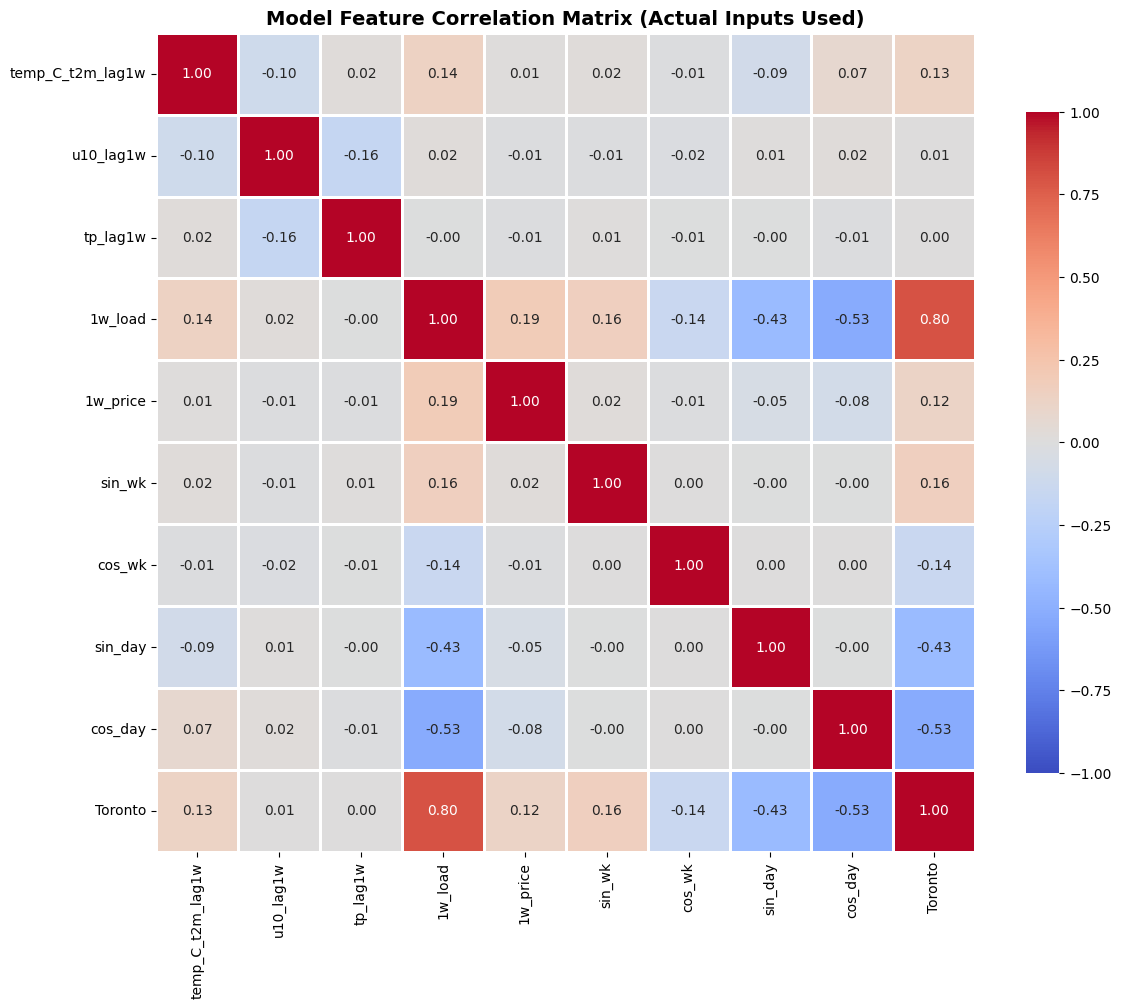


Highly correlated feature pairs (|r| > 0.7):
  1w_load <-> Toronto: 0.800


In [16]:
#feature engineering pipeline
import numpy as np

toronto_data = datamerged[datamerged['file'] == 'Toronto_centroid_weather'].copy()
toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
toronto_data = toronto_data[(toronto_data['Date'].dt.year >= 2018) & 
                            (toronto_data['Date'].dt.year <= 2024)]
toronto_data = toronto_data.set_index('Date').sort_index()

# fourier
toronto_data["t"] = np.arange(len(toronto_data))
period_weekly = 24 * 7
toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)

# lagged weather vars
toronto_data['temp_C_t2m_lag1w'] = toronto_data['temp_C_t2m'].shift(168)
toronto_data['u10_lag1w'] = toronto_data['u10'].shift(168)
toronto_data['tp_lag1w'] = toronto_data['tp'].shift(168)

# lagged load and price
toronto_data['1w_load'] = toronto_data['Toronto'].shift(168)
toronto_data['1w_price'] = toronto_data['Toronto_Darlington'].shift(168)

# drop nan
toronto_data = toronto_data.dropna(subset=['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w', '1w_load', '1w_price'])

# select model features for correlation analysis (lagged versions + Fourier + current load)
model_continuous_features = [
    'temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w',  # Lagged weather (used in models)
    '1w_load', '1w_price',  # Lagged load and price
    'sin_wk', 'cos_wk', 'sin_day', 'cos_day',  # Fourier terms
    'Toronto'  # Target for reference
]
correlation_matrix = toronto_data[model_continuous_features].corr()

#heaptmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Model Feature Correlation Matrix (Actual Inputs Used)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#highly correlated pairs
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.7):")
for feat1, feat2, corr in high_corr:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

### 1.2 Variance Inflation Factor (VIF)

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# prepare features for VIF calculation 
vif_features = [
    'temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w',
    '1w_load', '1w_price',
    'sin_wk', 'cos_wk', 'sin_day', 'cos_day'
]
X_vif = toronto_data[vif_features].dropna()

# calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = vif_features
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(vif_features))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Variance Inflation Factors (Model Features):")
print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  VIF < 5: Low multicollinearity")
print("  5 ≤ VIF < 10: Moderate multicollinearity")
print("  VIF ≥ 10: High multicollinearity (potential concern)")

# check dummy variable multicollinearity
print("\n" + "="*80)
print("DUMMY VARIABLE MULTICOLLINEARITY")
print("="*80)
print("\nNote: One-hot encoded categorical variables have inherent multicollinearity:")
print("  - Hour dummies: 23 features (hour_1 to hour_23, reference=hour_0)")
print("  - Month dummies: 11 features (month_2 to month_12, reference=month_1)")
print("  - Weekday dummies: 6 features (weekday_1 to weekday_6, reference=weekday_0)")
print("\nThis is expected and addressed by dropping one reference category.")
print("VIF for dummy variables would be extremely high - not meaningful to calculate.")

Variance Inflation Factors (Model Features):
         Feature    VIF
         1w_load 2.4931
temp_C_t2m_lag1w 2.0284
        1w_price 1.1820
       u10_lag1w 1.1319
        tp_lag1w 1.1074
         cos_day 1.0405
         sin_day 1.0076
          sin_wk 1.0014
          cos_wk 1.0008

Interpretation:
  VIF < 5: Low multicollinearity
  5 ≤ VIF < 10: Moderate multicollinearity
  VIF ≥ 10: High multicollinearity (potential concern)

DUMMY VARIABLE MULTICOLLINEARITY

Note: One-hot encoded categorical variables have inherent multicollinearity:
  - Hour dummies: 23 features (hour_1 to hour_23, reference=hour_0)
  - Month dummies: 11 features (month_2 to month_12, reference=month_1)
  - Weekday dummies: 6 features (weekday_1 to weekday_6, reference=weekday_0)

This is expected and addressed by dropping one reference category.
VIF for dummy variables would be extremely high - not meaningful to calculate.


## 2. Feature Preparation with Groups

Based on correlation/VIF analysis, define feature groups for removal experiments

In [18]:
# Import data preparation function from training notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# ============================================================================
# Reusable Data Preparation Pipeline should work for all the data models
# ============================================================================

def prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=None,
    extra_lags=None,  # list of tuples: (original_col, new_name, lag_hours)
    test_weeks=1,
    include_daily_seasonality=True
):
    """
    Prepare Toronto load data for time series modeling.
    
    parameters:
    datamerged : pd.DataFrame
        The merged dataset with all features
    zone : str
        Location identifier to filter by
    weather_vars : list, optional
        List of weather variables to use.
    extra_lags : list of tuples, optional
        Each tuple: (column_name, new_column_name, lag_hours)
    test_weeks : int
        Number of weeks for test set (default: 1 week = 168 hours)
    include_daily_seasonality : bool
        Whether to include daily sin/cos features (default: True)
    
    Returns:
    --------
    dict containing:
        - 'train': training dataset with datetime index
        - 'test': test dataset with datetime index
        - 'target_train': target variable for training
        - 'target_test': target variable for testing
        - 'exog_features': list of exogenous feature column names
        - 'toronto_data': full processed dataset
    """
    
    if weather_vars is None:
        weather_vars = ['temp_C_t2m', 'u10', 'tp']
    if extra_lags is None:
        extra_lags = []
    
    hours_per_week = 168
    
    # filter and prepare
    toronto_data = datamerged[datamerged['file'] == zone].copy()
    toronto_data['Date'] = pd.to_datetime(toronto_data['Date'])
    toronto_data = toronto_data.set_index('Date').sort_index()
    
    # time index for fourier terms
    toronto_data["t"] = np.arange(len(toronto_data))
    
    # weekly seasonality
    period_weekly = 24 * 7
    toronto_data["sin_wk"] = np.sin(2 * np.pi * toronto_data["t"] / period_weekly)
    toronto_data["cos_wk"] = np.cos(2 * np.pi * toronto_data["t"] / period_weekly)
    
    # daily seasonality 
    if include_daily_seasonality:
        toronto_data["sin_day"] = np.sin(2 * np.pi * toronto_data["t"] / 24)
        toronto_data["cos_day"] = np.cos(2 * np.pi * toronto_data["t"] / 24)
    
    # lag weather variables by 1 week
    for var in weather_vars:
        toronto_data[f'{var}_lag1w'] = toronto_data[var].shift(168)
    
    # lag extra columns by custom hours
    for col, new_name, lag_hours in extra_lags:
        toronto_data[new_name] = toronto_data[col].shift(lag_hours)
    
    # drop rows with NaN after lagging. this happens at the start sometimes.
    cols_to_check = [f'{v}_lag1w' for v in weather_vars] + ['Toronto']
    if extra_lags:
        cols_to_check += [new_name for _, new_name, _ in extra_lags]
    toronto_data = toronto_data.dropna(subset=cols_to_check)
    
    # e xtract dummy variables 
    hour_dummies = [c for c in toronto_data.columns if c.startswith('hour_')][1:]
    month_dummies = [c for c in toronto_data.columns if c.startswith('month_')][1:]
    weekday_dummies = [c for c in toronto_data.columns if c.startswith('weekday_')][1:]
    
    # bild exogenous features list ---
    seasonal_features = ["sin_wk", "cos_wk"]
    if include_daily_seasonality:
        seasonal_features += ['sin_day', 'cos_day']

    exog_features = (
        hour_dummies +
        month_dummies +
        weekday_dummies +
        [f'{v}_lag1w' for v in weather_vars] +
        seasonal_features
    )
    
    # holidays addition
    if 'IsHoliday' in toronto_data.columns:
        exog_features += ['IsHoliday']
    
    if extra_lags:
        exog_features += [new_name for _, new_name, _ in extra_lags]
    
    # train/test split
    train = toronto_data.iloc[:-hours_per_week * test_weeks]
    test = toronto_data.iloc[-hours_per_week * test_weeks:]
    
    # ensure numeric for exogenous features
    for df in [train, test]:
        df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
    
    target_train = train['Toronto'].astype(float)
    target_test = test['Toronto'].astype(float)
    
    return {
        'train': train,
        'test': test,
        'target_train': target_train,
        'target_test': target_test,
        'exog_features': exog_features,
        'toronto_data': toronto_data
    }

print("Data preparation function loaded")

Data preparation function loaded


## 3. Feature Importance by Model

### 3.1 Bayesian Ridge Regression: Coefficient Analysis

In [19]:
# prepare data
data = prepare_toronto_load_data(
    datamerged,
    zone='Toronto_centroid_weather',
    weather_vars=['temp_C_t2m', 'u10', 'tp'],
    extra_lags=[
        ('Toronto', '1w_load', 168),
        ('Toronto_Darlington', '1w_price', 168)
    ],
    test_weeks=40,
    include_daily_seasonality=True
)

train = data['train']
test = data['test']
target_train = data['target_train']
target_test = data['target_test']
exog_features = data['exog_features']

# train model brr
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[exog_features].astype(float))
X_test_scaled = scaler.transform(test[exog_features].astype(float))

model = BayesianRidge()
model.fit(X_train_scaled, target_train)

# analyze coefficients
feature_importance = pd.DataFrame({
    'Feature': exog_features,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 20 Most Important Features (Bayesian Ridge):")
print(feature_importance.head(20).to_string(index=False))


Top 20 Most Important Features (Bayesian Ridge):
         Feature  Coefficient  Abs_Coefficient
         1w_load     648.6490         648.6490
         cos_day    -208.0538         208.0538
         sin_day    -157.1419         157.1419
       IsHoliday    -107.9885         107.9885
          cos_wk      88.0132          88.0132
          sin_wk     -47.6029          47.6029
        1w_price     -14.0344          14.0344
       u10_lag1w      10.7257          10.7257
temp_C_t2m_lag1w      10.6848          10.6848
        tp_lag1w      -0.9585           0.9585


/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_2960/927439893.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
/var/folders/b8/b4rqhqs11cbcqlzjryxb92lw0000gn/T/ipykernel_2960/927439893.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[exog_features] = df[exog_features].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


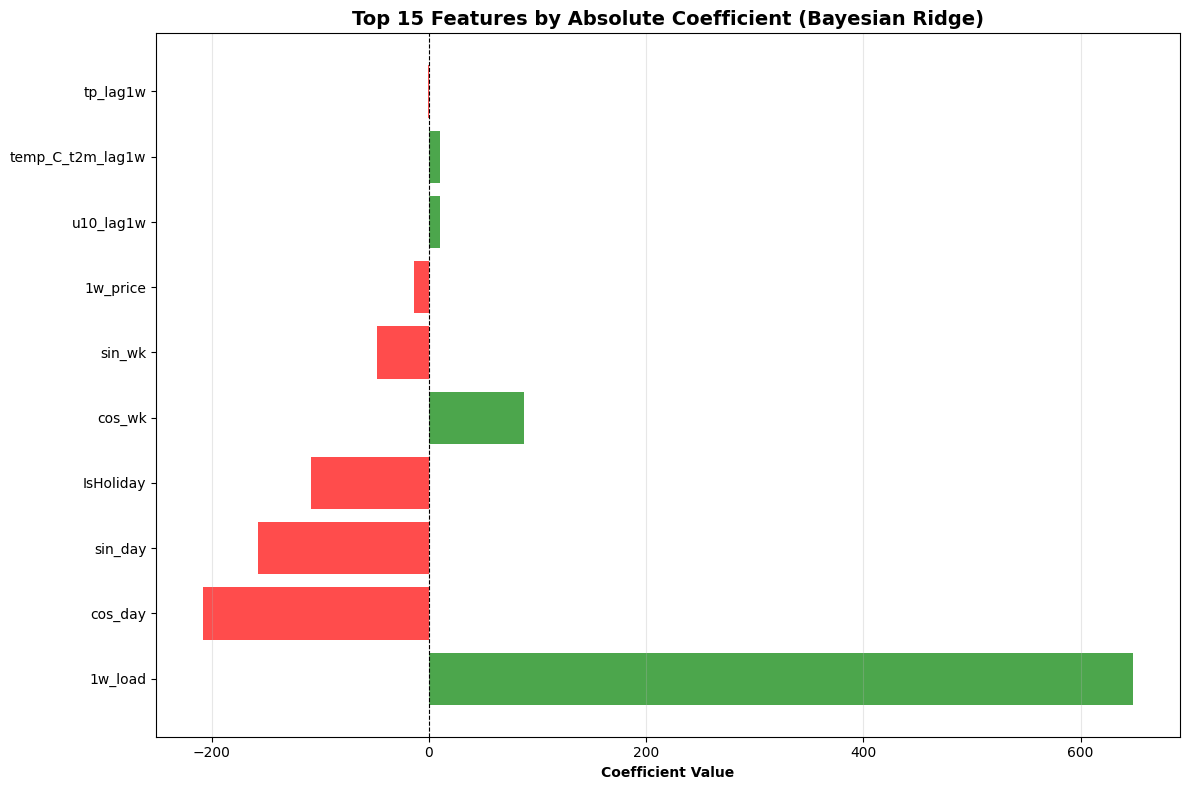

In [7]:
# visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontweight='bold')
plt.title(f'Top {top_n} Features by Absolute Coefficient (Bayesian Ridge)', 
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 ARIMAX: Coefficient Significance

In [8]:
# arimax on training set
arimax_model = SARIMAX(
    target_train,
    exog=train[exog_features],
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_results = arimax_model.fit(disp=False)

# coefficient information
params = arimax_results.params
pvalues = arimax_results.pvalues
tvalues = arimax_results.tvalues

#  exogenous variables only (exclude AR/MA parameters)
exog_params = params[params.index.isin(exog_features)]
exog_pvalues = pvalues[pvalues.index.isin(exog_features)]
exog_tvalues = tvalues[tvalues.index.isin(exog_features)]

arimax_importance = pd.DataFrame({
    'Feature': exog_params.index,
    'Coefficient': exog_params.values,
    'P-value': exog_pvalues.values,
    'T-statistic': exog_tvalues.values,
    'Significant': exog_pvalues.values < 0.05
}).sort_values('P-value')

print("\nTop 20 Most Significant Features (ARIMAX):")
print(arimax_importance.head(20).to_string(index=False))
print(f"\nSignificant features (p < 0.05): {arimax_importance['Significant'].sum()} / {len(arimax_importance)}")

/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/isaacwood/Documents/School/CISC 451/IESO ML Project/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

### 3.3 Prophet: Regressor Components

In [ ]:

# For feature analysis, train Prophet model on full training set

full = data["toronto_data"]
test_start_idx = full.index.get_loc(test.index[0])
train_df = full.iloc[:test_start_idx]

# remove Fourier terms from exogenous features since it's captured in prophets seasonal components
fourier_terms = [f for f in exog_features if 'sin' in f or 'cos' in f]
exog_features = [f for f in exog_features if f not in fourier_terms]
print("Exogenous features used:", exog_features)


prophet_train = pd.DataFrame({
    "ds": train_df.index,
    "y": train_df["Toronto"]
})

for col in exog_features:
    prophet_train[col] = train_df[col].values

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    interval_width=0.95
)

for col in exog_features:
    prophet_model.add_regressor(col)


prophet_model.fit(prophet_train)
print("Prophet model trained")

from prophet.utilities import regressor_coefficients
regressor_coef = regressor_coefficients(prophet_model)
regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')

Exogenous features used: ['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w', 'IsHoliday', '1w_load', '1w_price']


13:35:17 - cmdstanpy - INFO - Chain [1] start processing
13:35:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained


,regressor,regressor_mode,coef
3,IsHoliday,additive,-686.6216
0,temp_C_t2m_lag1w,additive,-5.3818
1,u10_lag1w,additive,-0.2138
5,1w_price,additive,-0.0081
4,1w_load,additive,0.3136
2,tp_lag1w,additive,1703.1468


In [31]:
#print prophet rmse
rmse = np.sqrt(mean_squared_error(target_train, prophet_model.predict(prophet_train)['yhat']))
rmse

np.float64(465.3970866117892)

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def prophet_permutation_importance(model, df, exog_features, metric=mean_absolute_error):
    """
    Compute permutation importance for a fitted Prophet model.
    
    Parameters:
        model: Fitted Prophet model
        df: DataFrame used for prediction (must contain ds, y, and regressors)
        exog_features: List of regressor names
        metric: Error metric function (default MAE)
        
    Returns:
        Dictionary of feature: importance_score
    """
    
    # baseline predictioj
    baseline_pred = model.predict(df)
    baseline_err = metric(df['y'], baseline_pred['yhat'])

    importances = {}

    for col in exog_features:
        df_permuted = df.copy()
        df_permuted[col] = np.random.permutation(df_permuted[col])

        pred = model.predict(df_permuted)
        err = metric(df['y'], pred['yhat'])

        importances[col] = err - baseline_err  # Error increase

    return dict(sorted(importances.items(), key=lambda x: -x[1]))




# same dataset
importance_scores = prophet_permutation_importance(
    prophet_model,
    prophet_train,
    exog_features,
    metric=mean_absolute_error
)

importance_scores


{'1w_load': 164.62657232057785,
 'IsHoliday': 16.65273236499189,
 'temp_C_t2m_lag1w': 8.008813050231709,
 'tp_lag1w': 0.0012189083527687217,
 '1w_price': -0.006610993377535124,
 'u10_lag1w': -0.014721887446683013}

## 4. Feature Ablation Study

Systematically remove feature groups and measure performance degradation

In [ ]:
# define feature groups
feature_groups = {
    'Weather': ['temp_C_t2m_lag1w', 'u10_lag1w', 'tp_lag1w'],
    'Price': ['1w_price'],
    'Historical Load': ['1w_load'],
    'Fourier (Weekly)': ['sin_wk', 'cos_wk'],
    'Fourier (Daily)': ['sin_day', 'cos_day'],
    'Hour Dummies': [c for c in exog_features if c.startswith('hour_')],
    'Month Dummies': [c for c in exog_features if c.startswith('month_')],
    'Weekday Dummies': [c for c in exog_features if c.startswith('weekday_')],
    'Holiday': ['IsHoliday'] if 'IsHoliday' in exog_features else []
}

print("Feature Groups Defined:")
for group_name, features in feature_groups.items():
    if features:
        print(f"  {group_name}: {len(features)} features")

Feature Groups Defined:
  Weather: 3 features
  Price: 1 features
  Historical Load: 1 features
  Fourier (Weekly): 2 features
  Fourier (Daily): 2 features
  Holiday: 1 features


### 4.1 Ablation with Bayesian Ridge (Fast)

In [ ]:
# Baseline performance
pred_baseline = model.predict(X_test_scaled)
baseline_rmse = np.sqrt(mean_squared_error(target_test, pred_baseline))
baseline_mae = mean_absolute_error(target_test, pred_baseline)

print(f"Baseline (All Features):")
print(f"  RMSE: {baseline_rmse:.2f} MW")
print(f"  MAE: {baseline_mae:.2f} MW")

# ablation results
ablation_results = []

for group_name, features_to_remove in feature_groups.items():
    if not features_to_remove:
        continue
    
    # create feature set without this group
    remaining_features = [f for f in exog_features if f not in features_to_remove]
    
    if len(remaining_features) == 0:
        continue
    
    # train model without this group
    X_train_ablated = train[remaining_features].astype(float)
    X_test_ablated = test[remaining_features].astype(float)
    
    scaler_ablated = StandardScaler()
    X_train_scaled_ablated = scaler_ablated.fit_transform(X_train_ablated)
    X_test_scaled_ablated = scaler_ablated.transform(X_test_ablated)
    
    model_ablated = BayesianRidge()
    model_ablated.fit(X_train_scaled_ablated, target_train)
    
    pred_ablated = model_ablated.predict(X_test_scaled_ablated)
    rmse_ablated = np.sqrt(mean_squared_error(target_test, pred_ablated))
    mae_ablated = mean_absolute_error(target_test, pred_ablated)
    
    ablation_results.append({
        'Feature Group': group_name,
        'Features Removed': len(features_to_remove),
        'RMSE': rmse_ablated,
        'MAE': mae_ablated,
        'RMSE Change': rmse_ablated - baseline_rmse,
        'MAE Change': mae_ablated - baseline_mae,
        'RMSE % Change': ((rmse_ablated - baseline_rmse) / baseline_rmse * 100)
    })

ablation_df = pd.DataFrame(ablation_results).sort_values('RMSE Change', ascending=False)

print("\n" + "="*80)
print("FEATURE ABLATION RESULTS (Bayesian Ridge)")
print("="*80)
print(ablation_df.to_string(index=False))
print("\nInterpretation: Positive change = performance degraded when group removed")

Baseline (All Features):
  RMSE: 481.24 MW
  MAE: 356.65 MW

FEATURE ABLATION RESULTS (Bayesian Ridge)
   Feature Group  Features Removed     RMSE      MAE  RMSE Change  MAE Change  RMSE % Change
 Historical Load                 1 612.1569 489.7471     130.9214    133.0961        27.2053
 Fourier (Daily)                 2 510.1144 360.2825      28.8789      3.6315         6.0010
         Holiday                 1 495.7828 366.5603      14.5473      9.9093         3.0229
Fourier (Weekly)                 2 484.9737 352.5787       3.7382     -4.0723         0.7768
           Price                 1 481.5257 356.8998       0.2902      0.2488         0.0603
         Weather                 3 481.4144 356.1157       0.1789     -0.5352         0.0372

Interpretation: Positive change = performance degraded when group removed


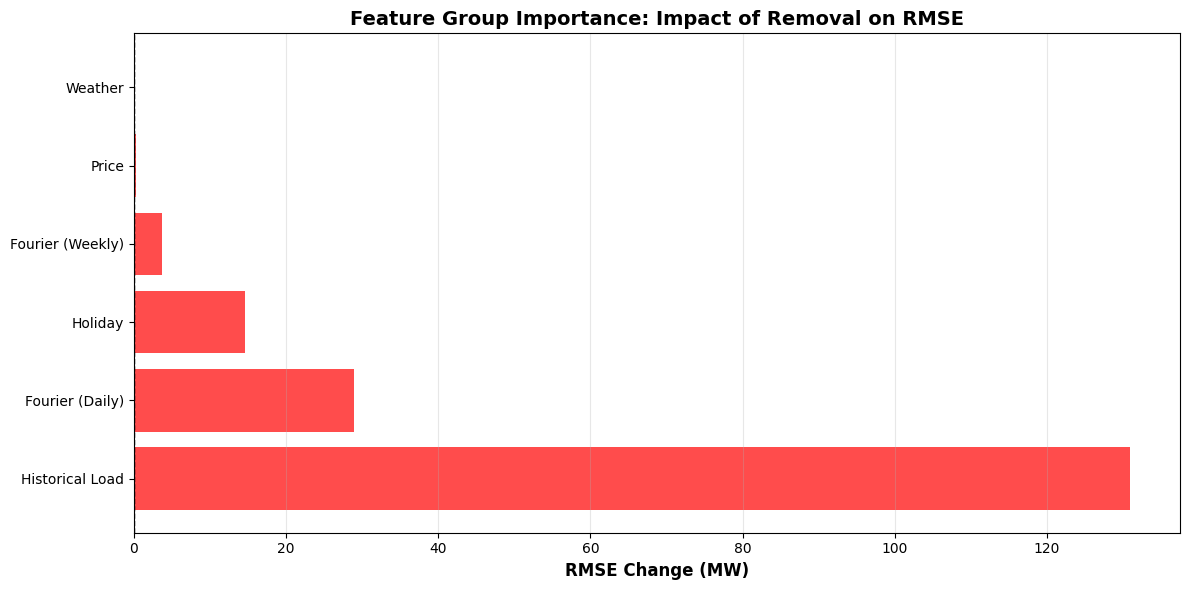

In [11]:
# Visualize ablation impact
plt.figure(figsize=(12, 6))
colors = ['red' if x > 0 else 'green' for x in ablation_df['RMSE Change']]
plt.barh(ablation_df['Feature Group'], ablation_df['RMSE Change'], color=colors, alpha=0.7)
plt.xlabel('RMSE Change (MW)', fontweight='bold', fontsize=12)
plt.title('Feature Group Importance: Impact of Removal on RMSE', 
          fontweight='bold', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary and Conclusions

In [32]:
print("="*80)
print("RQ2 ANALYSIS SUMMARY")
print("="*80)
print("\n1. MULTICOLLINEARITY:")
print(f"   - Features with high VIF (>10): {len(vif_data[vif_data['VIF'] >= 10])}")
print(f"   - Highly correlated pairs (|r|>0.7): {len(high_corr)}")

print("\n2. MOST IMPORTANT FEATURES (Bayesian Ridge):")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Coefficient']:.4f}")

print("\n3. FEATURE GROUPS WITH LARGEST IMPACT WHEN REMOVED:")
for i, row in ablation_df.head(5).iterrows():
    print(f"   - {row['Feature Group']}: +{row['RMSE Change']:.2f} MW ({row['RMSE % Change']:.1f}%)")

print("\n4. FEATURE GROUPS WITH MINIMAL IMPACT:")
for i, row in ablation_df.tail(3).iterrows():
    print(f"   - {row['Feature Group']}: {row['RMSE Change']:+.2f} MW ({row['RMSE % Change']:+.1f}%)")

print("\n" + "="*80)

RQ2 ANALYSIS SUMMARY

1. MULTICOLLINEARITY:
   - Features with high VIF (>10): 0
   - Highly correlated pairs (|r|>0.7): 1

2. MOST IMPORTANT FEATURES (Bayesian Ridge):
   - 1w_load: 648.6490
   - cos_day: -208.0538
   - sin_day: -157.1419
   - IsHoliday: -107.9885
   - cos_wk: 88.0132

3. FEATURE GROUPS WITH LARGEST IMPACT WHEN REMOVED:
   - Historical Load: +130.92 MW (27.2%)
   - Fourier (Daily): +28.88 MW (6.0%)
   - Holiday: +14.55 MW (3.0%)
   - Fourier (Weekly): +3.74 MW (0.8%)
   - Price: +0.29 MW (0.1%)

4. FEATURE GROUPS WITH MINIMAL IMPACT:
   - Fourier (Weekly): +3.74 MW (+0.8%)
   - Price: +0.29 MW (+0.1%)
   - Weather: +0.18 MW (+0.0%)

